# Code 4: Extending Linear Models

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
from scipy import stats
import bambi as bmb
import seaborn as sns
from plotnine import *

import theano.tensor as tt
import theano

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-05-10 08:39:36.498003


In [2]:
# az.style.use("arviz-grayscale")
# plt.rcParams['figure.dpi'] = 300 
# themes.theme_set('theme_bw')
az.style.use("arviz-grayscale")
# plt.rcParams['figure.dpi'] = 300
pd.set_option('display.max_columns', 500)

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

In [3]:
%load_ext watermark
%watermark --iversions

bambi     : 0.6.3
numpy     : 1.19.5
seaborn   : 0.11.2
scipy     : 1.7.1
pymc3     : 3.11.4
pandas    : 1.3.2
theano    : 1.1.2
arviz     : 0.11.2
matplotlib: 3.4.3



# 4.1 Transforming Covariates

### Code 4.1

In [4]:
babies = pd.read_csv('data/babies.csv')

# Add a constant term so we can use a the dot product approach
babies["Intercept"] = 1

babies.head()

,Month,Length,Intercept
0,0,48.5,1
1,0,50.5,1
2,0,50.5,1
3,0,52.0,1
4,0,47.5,1


In [5]:
babies.tail()

,Month,Length,Intercept
795,24,87.5,1
796,24,82.5,1
797,24,88.5,1
798,24,89.0,1
799,24,87.0,1


In [6]:
babies.describe()

,Month,Length,Intercept
count,800.000000,800.000000,800.0
mean,11.425000,71.664375,1.0
std,7.512151,11.274265,0.0
min,0.000000,45.500000,1.0
25%,5.000000,64.000000,1.0
50%,11.000000,72.500000,1.0
75%,18.000000,81.000000,1.0
max,24.000000,93.000000,1.0


### Figure 4.1

In [7]:
# fig, ax = plt.subplots()

# ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)
# ax.set_ylabel("Length")
# ax.set_xlabel("Month");
# plt.savefig('img/chp04/baby_length_scatter.png', dpi=300)

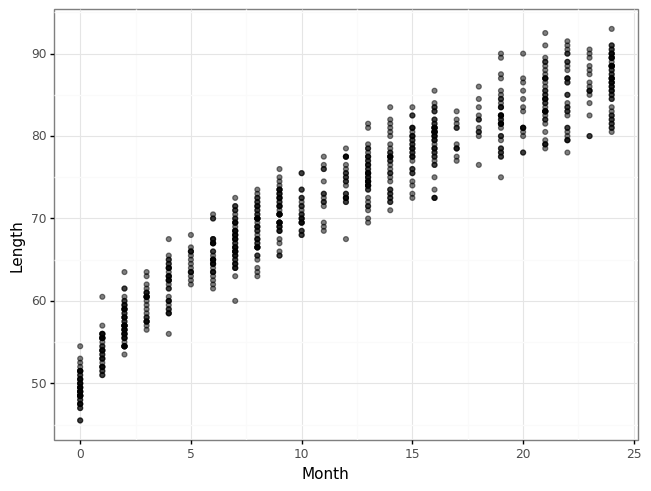

In [8]:
p = (ggplot(babies, aes(x='Month', y='Length')) +
     geom_point(alpha=0.5) +
     theme_bw()
    )
p.draw();

### Code 4.2

In [9]:
with pm.Model() as model_baby_linear:
    # Create 2 normal distributions centred at 0, with stdev of 10 
    β = pm.Normal('β', sigma=10, shape=2)
    # Shape - β (n_chains, n_draws, allocated by shape keyword)
    # β (1, 500, 2)
    
    # Cannot understand this - what does this mean?
    # Use dot product instead of expanded multiplication
    # Data is (800, 2) (data length, n_covariates) - Maybe the data is shaped to (1, 800, 2) so the dims are the same ?
    # β is (1, 500, 2) (b_chains, n_draws, shape)
    mu = pm.Deterministic("mu", pm.math.dot(babies[["Intercept", "Month"]], β))
    # mu is collapsed down to (1 x 800 x 2) dot prod (1, 500, 2) (1, 500, 800) ?????????? Don't get this ??????
    # mu (n_chains, n_draws, data length)
    # mu (1, 500, 800)
        
    μ = pm.Deterministic("μ", mu)
    ϵ = pm.HalfNormal("ϵ", sigma=10)
    # ϵ (n_chains, n_draws)
    # ϵ (1, 500)
    
    length = pm.Normal("length", mu=μ, sigma=ϵ, observed=babies["Length"])
    # length (n_chains, n_draws, data length)
    # length (1, 500, 800)
    
    prior_dict = pm.sample_prior_predictive()
    idata_baby_linear = az.from_pymc3(prior=prior_dict)

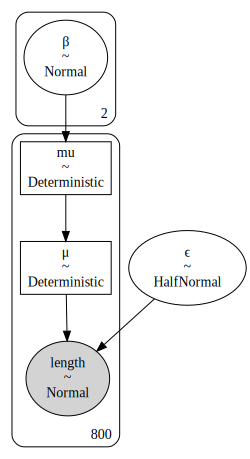

In [10]:
pm.model_to_graphviz(model_baby_linear)

In [11]:
print(babies[["Intercept", "Month"]].shape)
print(idata_baby_linear.prior['β'].shape)
print(idata_baby_linear.prior['μ'].shape)
print(idata_baby_linear.prior['ϵ'].shape)
print(idata_baby_linear.prior_predictive['length'].shape)

(800, 2)
(1, 500, 2)
(1, 500, 800)
(1, 500)
(1, 500, 800)


In [12]:
idata_baby_linear

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [13]:
mu_df = idata_baby_linear.prior[['mu', 'ϵ']].to_dataframe()
mu_df.head()

mu         ϵ
chain draw mu_dim_0                    
0     0    0        -0.933055  6.894148
           1        -0.933055  6.894148
           2        -0.933055  6.894148
           3        -0.933055  6.894148
           4        -0.933055  6.894148

In [14]:
def marry_prior_preds_to_input_data(idata, df_input):
    # flatten & rename var so no clash with input df
    prior_df = idata.prior_predictive.to_dataframe().reset_index()
    prior_df = prior_df.rename(columns={col: 'priorpred_' + col for col in 
                                        prior_df.columns if col not in ('chain', 'draw') and ('dim' not in col)})
    # make index for merge purposes
    df_input = df_input.reset_index()
    # Get left merge key - same length as original data
    left_on = list(idata.prior_predictive.coords.dims.keys())[-1]
    
    return prior_df.merge(df_input, left_on=left_on, right_on='index').sort_values(by = ['chain', 'draw', left_on]).reset_index(drop=True)    

In [15]:
prior_df = marry_prior_preds_to_input_data(idata_baby_linear, babies)
prior_df.head()

,chain,draw,length_dim_0,priorpred_length,index,Month,Length,Intercept
0,0,0,0,-9.621723,0,0,48.5,1
1,0,0,1,-1.597307,1,0,50.5,1
2,0,0,2,-18.207338,2,0,50.5,1
3,0,0,3,5.497673,3,0,52.0,1
4,0,0,4,4.219791,4,0,47.5,1


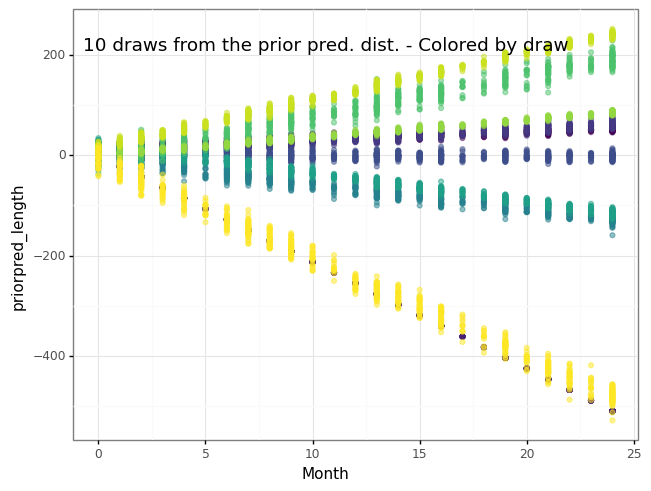

In [16]:
df1 = prior_df.copy()
# number of samples from the draws
n_samples = 10
random_draws = np.random.choice(df1['draw'].unique(), n_samples)
df1 = df1[df1['draw'].isin(random_draws)]
p = (ggplot(df1, aes(x='Month', y='priorpred_length', colour='draw')) +
     geom_point(alpha=0.5, show_legend=False) +
     labs(title=f'{n_samples} draws from the prior pred. dist. - Colored by draw') +
     theme_bw()
    )
p.draw();

In [17]:
with model_baby_linear:
    trace_linear = pm.sample(draws=2000, tune=4000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    inf_data_linear = az.from_pymc3(prior=prior_dict,
                                    trace=trace_linear,
                                    posterior_predictive=pcc_linear)

/tmp/ipykernel_50322/1907677405.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5566569031254606, but should be close to 0.8. Try to increase the number of tuning steps.


In [18]:
inf_data_linear

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [19]:
def posterior_predictive_hdi(idata, var_name, hdi_prob=95):
    hdi_df = az.hdi(idata.posterior_predictive[var_name], hdi_prob=hdi_prob).to_dataframe().reset_index().pivot(index=var_name + '_dim_0', columns='hdi').reset_index()
    hdi_df.columns = ['_'.join(col).strip().strip('_') for col in hdi_df.columns.values]
    return hdi_df

mu_mean = pd.concat([pd.DataFrame(inf_data_linear.posterior['μ'].to_dataframe().reset_index().groupby(by=['μ_dim_0'])['μ'].mean()), babies], axis=1)
length_50hdi = posterior_predictive_hdi(inf_data_linear, 'length', hdi_prob=0.50).assign(set='0.50hdi')
length_95hdi = posterior_predictive_hdi(inf_data_linear, 'length', hdi_prob=0.95).assign(set='0.95hdi')
hdi_df = pd.concat([pd.concat([length_50hdi, babies], axis=1), pd.concat([length_95hdi, babies], axis=1)], axis=0)
hdi_df

,length_dim_0,length_higher,length_lower,set,Month,Length,Intercept
0,0,57.921302,53.297387,0.50hdi,0,48.5,1
1,1,57.661058,53.072343,0.50hdi,0,50.5,1
2,2,57.466359,52.802368,0.50hdi,0,50.5,1
3,3,57.617658,53.045790,0.50hdi,0,52.0,1
4,4,58.079484,53.357881,0.50hdi,0,47.5,1
...,...,...,...,...,...,...,...
795,795,96.489903,82.778273,0.95hdi,24,87.5,1
796,796,96.387216,82.753612,0.95hdi,24,82.5,1
797,797,96.306438,82.621749,0.95hdi,24,88.5,1
798,798,96.381227,82.807958,0.95hdi,24,89.0,1


In [20]:
mu_mean
mu_mean.groupby(by='Month').first().reset_index().head()

,Month,μ,Length,Intercept
0,0,55.322407,48.5,1
1,1,56.752129,51.5,1
2,2,58.181851,54.5,1
3,3,59.611573,57.5,1
4,4,61.041294,64.0,1


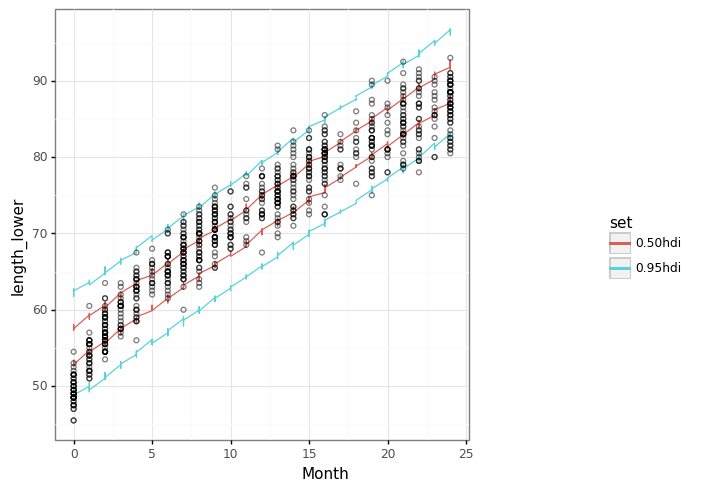

In [21]:
p = (ggplot(hdi_df, aes(x='Month', color='set')) +
     geom_line(aes(y='length_lower')) +
     geom_line(aes(y='length_higher')) +
     # geom_line(mu_mean.groupby(by='Month').first().reset_index(), aes(x='Month', y='μ')) +
     geom_point(aes(y='Length'), fill='none', color='black', alpha=0.3) +
     theme_bw()
    )
p.draw();

In [22]:
# μ_m = inf_data_linear.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)
# μ_m

In [23]:
    # trace_linear = pm.sample(draws=2000, tune=4000)
    # pcc_linear = pm.sample_posterior_predictive(trace_linear)
    # inf_data_linear = az.from_pymc3(trace=trace_linear,
    #                                 posterior_predictive=pcc_linear)

In [24]:
# inf_data_linear.posterior_predictive["length"]

### Figure 4.2

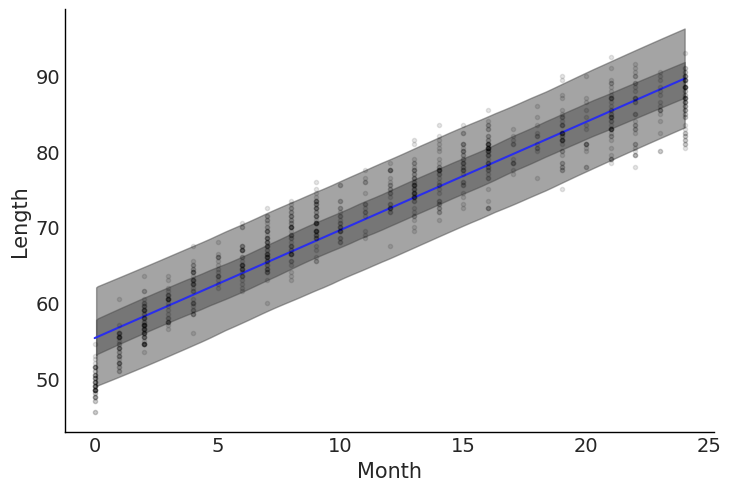

In [25]:
fig, ax = plt.subplots()

ax.set_ylabel("Length")
ax.set_xlabel("Month");

μ_m = inf_data_linear.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

ax.plot(babies["Month"], μ_m, c='C4')
az.plot_hdi(babies["Month"], inf_data_linear.posterior_predictive["length"], hdi_prob=.50, ax=ax)
az.plot_hdi(babies["Month"], inf_data_linear.posterior_predictive["length"], hdi_prob=.94, ax=ax)

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

plt.savefig('img/chp04/baby_length_linear_fit.png', dpi=300)

In [26]:
az.loo(inf_data_linear)

Computed from 8000 by 800 log-likelihood matrix

         Estimate       SE
elpd_loo -2133.30    18.60
p_loo        3.21        -

### Code 4.3

In [27]:
with pm.Model() as model_baby_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)
    # β (4, 2000, 2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.HalfNormal("σ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])
    inf_data_sqrt = pm.sample(draws=2000, tune=4000)

    
    ppc_baby_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt = az.from_pymc3(trace=inf_data_sqrt,
                                  posterior_predictive=ppc_baby_sqrt)

/tmp/ipykernel_50322/2820222739.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 6 seconds.


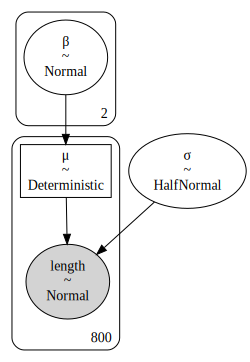

In [28]:
pm.model_to_graphviz(model_baby_sqrt)

In [29]:
print(inf_data_sqrt.posterior['β'].shape)
print(inf_data_sqrt.posterior['μ'].shape)
print(inf_data_sqrt.posterior['σ'].shape)
print(inf_data_sqrt.posterior_predictive['length'].shape)

(4, 2000, 2)
(4, 2000, 800)
(4, 2000)
(4, 2000, 800)


In [30]:
inf_data_sqrt.posterior['β'].to_dataframe()

β
chain draw β_dim_0           
0     0    0        46.362476
           1         8.126643
      1    0        46.361399
           1         8.095619
      2    0        46.709008
...                       ...
3     1997 1         8.125319
      1998 0        47.004046
           1         8.019298
      1999 0        46.672305
           1         8.067771

[16000 rows x 1 columns]

In [31]:
inf_data_sqrt

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

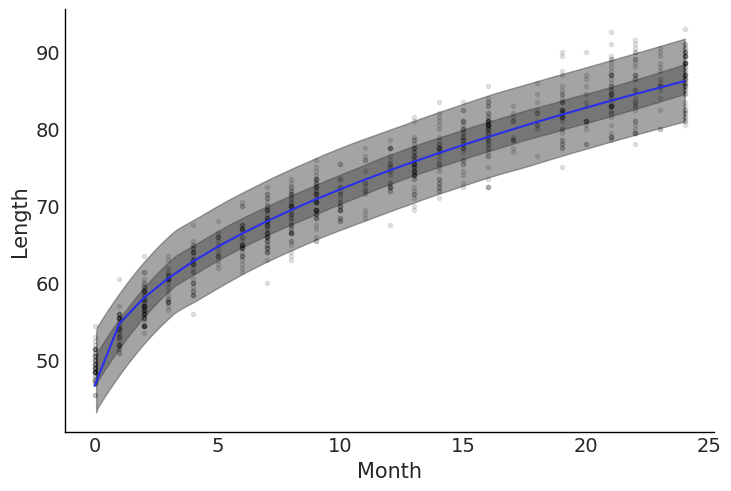

In [32]:
fig, ax = plt.subplots()

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

ax.set_ylabel("Length")
ax.set_xlabel("Month");

μ_m = inf_data_sqrt.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=ax)
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=ax)

ax.plot(babies["Month"], μ_m, c='C4')

plt.savefig('img/chp04/baby_length_sqrt_fit.png', dpi=300)

### Figure 4.3

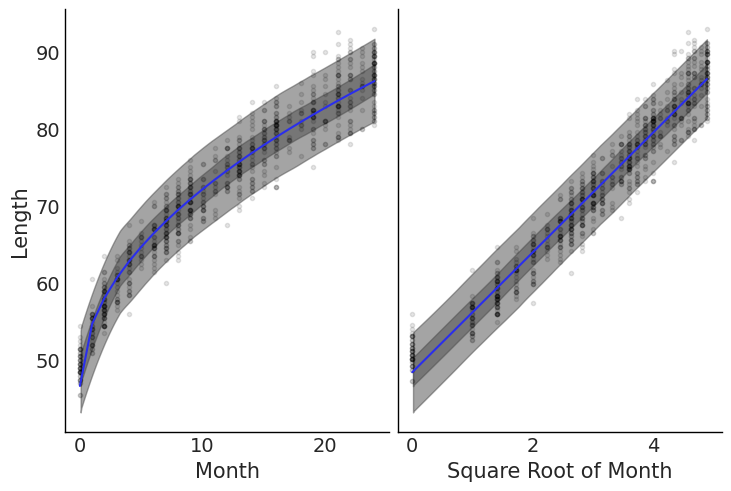

In [33]:
fig, axes = plt.subplots(1,2)
axes[0].plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = inf_data_sqrt.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

axes[0].plot(babies["Month"], μ_m, c='C4')
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[0])
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[0])

axes[0].set_ylabel("Length")
axes[0].set_xlabel("Month");

axes[1].plot(np.sqrt(babies["Month"]), babies["Length"], 'C0.', alpha=0.1)
axes[1].set_xlabel("Square Root of Month");

az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[1])
az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[1])
axes[1].plot(np.sqrt(babies["Month"]), μ_m, c='C4')

axes[1].set_yticks([])
axes[1]

plt.savefig('img/chp04/baby_length_sqrt_fit.png', dpi=300)

In [34]:
az.compare({"Linear Model":inf_data_linear, "Non Linear Model":inf_data_sqrt})

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Non Linear Model,0,-1968.269936,3.127280,0.000000,0.929182,18.952589,0.000000,False,log
Linear Model,1,-2133.303404,3.211619,165.033468,0.070818,18.604196,20.070441,False,log


## 4.1 Summary - Transforming Covariates
+ Found this section a bit confusing
    + I think the intent of the section is to show how transforming a covariate produces a better fitting model
    + But the first model uses a dot product and the second model expands the calculation, so I am not sure why they were not written identically 
    + It does not seem possible to view the shape of the variables from inside the model context, so this makes the above a bit confusing
    + This is probably just the author's showing an alternative ways of doing the same thing
    + The variables are renamed between the first and second model eg epsilon and sigma and I am not sure why - these are defined in the model context so I cannot see any potential for clashing
    + The prior predictive seems to allow babies to shrink to negative length - Maybe this washes out because there are 800 data points. Below priors are split

In [35]:
with pm.Model() as model_baby_linear:
    
    # Intercept is not ideal - a baby must have a minimum length, it cannot be 0 inches long, and it must have a maximum length - cannot be 4 feet long
    intercept = pm.HalfNormal('intercept', sigma=10)
    beta_month = pm.Normal('beta_month', sigma=10)

    mu = pm.Deterministic('mu', intercept + beta_month * babies['Month'].values)
    
    sigma = pm.HalfNormal("sigma", sigma=10)

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=babies["Length"].values)

    trace_linear = pm.sample(draws=2000, tune=4000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    inf_data_linear = az.from_pymc3(trace=trace_linear,
                                    posterior_predictive=pcc_linear)

/tmp/ipykernel_50322/3872063687.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_month, intercept]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8857467244396898, but should be close to 0.8. Try to increase the number of tuning steps.


In [36]:
# Rename and make a single change to the previous model - feed model square root of month instead of month
with pm.Model() as model_baby_sqrt:
    
    intercept = pm.HalfNormal('intercept', sigma=10)
    beta_month = pm.Normal('beta_month', sigma=10)
    
    # Single change to model - np.sqrt(babies['Month'].values)
    mu = pm.Deterministic('mu', intercept + beta_month * np.sqrt(babies['Month'].values))
    
    sigma = pm.HalfNormal("sigma", sigma=10)

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=babies["Length"].values)

    trace_sqrt = pm.sample(draws=2000, tune=4000)
    pcc_sqrt = pm.sample_posterior_predictive(trace_sqrt)
    inf_data_sqrt = az.from_pymc3(trace=trace_sqrt,
                                  posterior_predictive=pcc_sqrt)

/tmp/ipykernel_50322/4238459606.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_month, intercept]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 6 seconds.


<AxesSubplot:xlabel='Square Root of Month'>

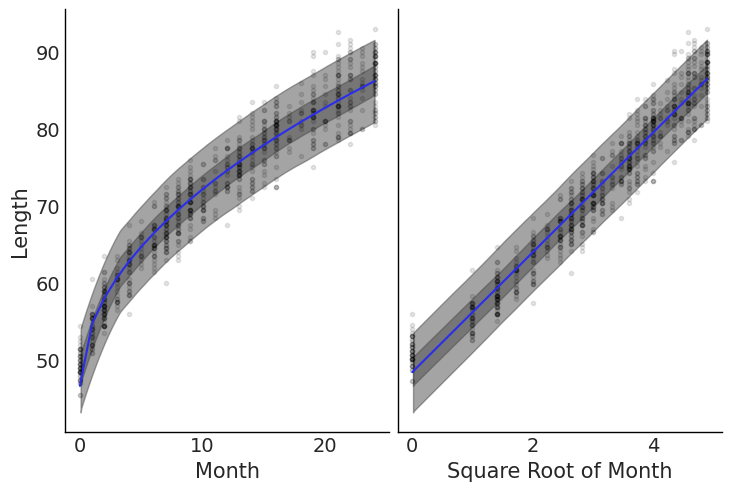

In [37]:
fig, axes = plt.subplots(1,2)
axes[0].plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = inf_data_sqrt.posterior["mu"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

axes[0].plot(babies["Month"], μ_m, c='C4')
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[0])
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[0])

axes[0].set_ylabel("Length")
axes[0].set_xlabel("Month");

axes[1].plot(np.sqrt(babies["Month"]), babies["Length"], 'C0.', alpha=0.1)
axes[1].set_xlabel("Square Root of Month");

az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[1])
az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[1])
axes[1].plot(np.sqrt(babies["Month"]), μ_m, c='C4')

axes[1].set_yticks([])
axes[1]

# plt.savefig('img/chp04/baby_length_sqrt_fit.png', dpi=300)

In [38]:
az.compare({"Linear Model":inf_data_linear, "Non Linear Model":inf_data_sqrt})

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Non Linear Model,0,-1968.252273,3.108566,0.000000,0.928784,18.976046,0.000000,False,log
Linear Model,1,-2133.358011,3.271372,165.105739,0.071216,18.618211,20.090513,False,log


---

# 4.2 Varying Uncertainty

### Code 4.4

In [39]:
with pm.Model() as model_baby_vv:
    β = pm.Normal("β", sigma=10, shape=2)

    # Additional variance terms
    δ = pm.HalfNormal("δ", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.Deterministic("σ", δ[0] + δ[1] * babies["Month"])

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    trace_baby_vv = pm.sample(2000, target_accept=.95)
    ppc_baby_vv = pm.sample_posterior_predictive(trace_baby_vv,
                                                 var_names=["length", "σ"])
    inf_data_baby_vv = az.from_pymc3(trace=trace_baby_vv,
                                     posterior_predictive=ppc_baby_vv)

/tmp/ipykernel_50322/3470835175.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [40]:
az.summary(inf_data_baby_vv, var_names=["δ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
δ[0],2.388,0.117,2.176,2.619,0.002,0.002,3050.0,3173.0,1.0
δ[1],0.038,0.009,0.020,0.055,0.000,0.000,3191.0,3095.0,1.0


<AxesSubplot:xlabel='Month', ylabel='Length'>

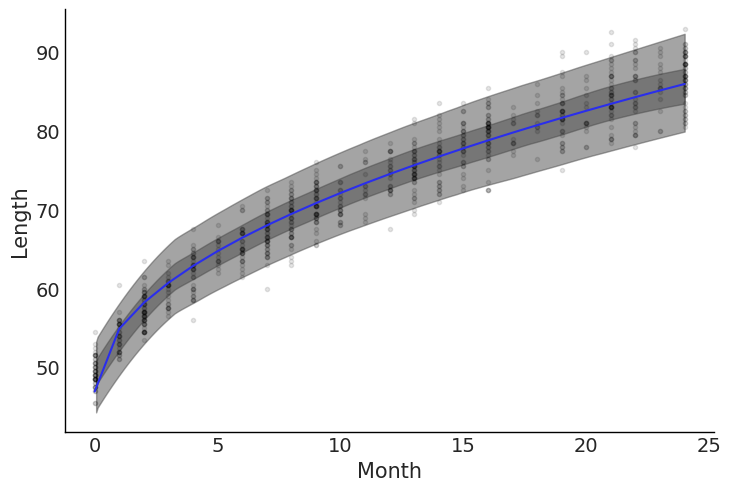

In [41]:
fig, ax = plt.subplots()

ax.set_ylabel("Length")
ax.set_xlabel("Month");

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = inf_data_baby_vv.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

ax.plot(babies["Month"], μ_m, c='C4')

az.plot_hdi(babies["Month"], inf_data_baby_vv.posterior_predictive["length"], hdi_prob=.50, ax=ax)
az.plot_hdi(babies["Month"], inf_data_baby_vv.posterior_predictive["length"], hdi_prob=.94, ax=ax)

# plt.savefig('img/chp04/baby_length_sqrt_vv_fit.png', dpi=300)

### Figure 4.4

(0.0, 24.0)

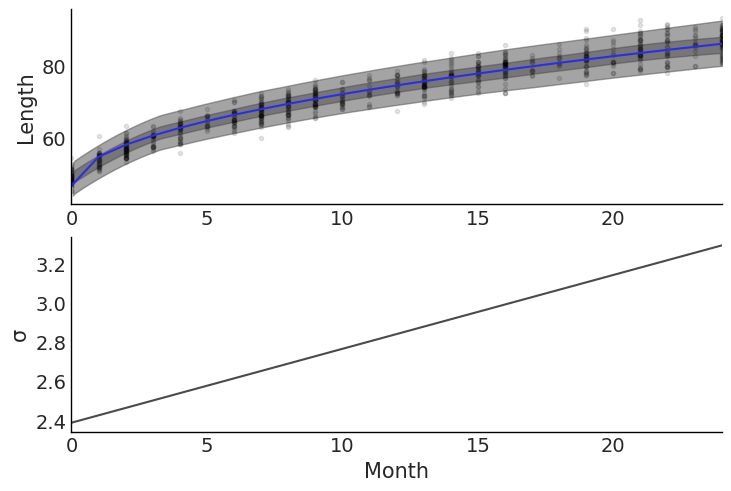

In [42]:
fig, axes = plt.subplots(2,1)

axes[0].plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = inf_data_baby_vv.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

axes[0].plot(babies["Month"], μ_m, c='C4')

az.plot_hdi(babies["Month"], inf_data_baby_vv.posterior_predictive["length"], hdi_prob=.50, ax=axes[0])
az.plot_hdi(babies["Month"], inf_data_baby_vv.posterior_predictive["length"], hdi_prob=.94, ax=axes[0])
axes[0].set_ylabel("Length")

σ_m = inf_data_baby_vv.posterior["σ"].values.reshape(-1, 800).mean(axis=0)

axes[1].plot(babies["Month"], σ_m, c='C1')

axes[1].set_ylabel("σ")
axes[1].set_xlabel("Month")

axes[0].set_xlim(0,24)
axes[1].set_xlim(0,24)

# plt.savefig('img/chp04/baby_length_sqrt_vv_fit_include_error.png', dpi=300)

In [43]:
az.compare({"Linear Model":inf_data_linear, "Non Linear Model":inf_data_sqrt, "Varying uncertainty": inf_data_baby_vv})

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Varying uncertainty,0,-1960.711314,3.925166,0.000000,9.275977e-01,18.792534,0.000000,False,log
Non Linear Model,1,-1968.252273,3.108566,7.540959,7.239800e-14,18.976046,3.710511,False,log
Linear Model,2,-2133.358011,3.271372,172.646698,7.240228e-02,18.618211,21.086354,False,log


## 4.3 Summary - Varying Uncertainty
+ Method seems fairly straight forward - Introduce new variable \delta to account for increasing dispersion over time
+ How to choose prior for this? - I guess in the original model we had to choose a prior for sigma, and this is just a more sophisticated way of choosing this.
+ The delta prior is in 2 parts - an intercept and a coeff to multiply the month as shown in plot above - This makes it very clear. If I had done this with no guidance I would just have chosen a prior to multiply by the month ???

---

In [44]:
stop

NameError: name 'stop' is not defined

# 4.3 Interaction effects

### Code 4.5

In [ ]:
tips_df = pd.read_csv('data/tips.csv')
tips_df.head()

In [ ]:
tips = tips_df["tip"]
total_bill_c = (tips_df["total_bill"] - tips_df["total_bill"].mean())  
smoker = pd.Categorical(tips_df["smoker"]).codes

with pm.Model() as model_no_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=3)
    σ = pm.HalfNormal("σ", 1)

    μ = (β[0] +
         β[1] * total_bill_c + 
         β[2] * smoker)

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_no_interaction = pm.sample(1000, tune=1000)

In [ ]:
_, ax = plt.subplots(figsize=(8, 4.5))

β0_nonint = trace_no_interaction['β'][:,0]
β1_nonint = trace_no_interaction['β'][:,1]
β2_nonint = trace_no_interaction['β'][:,2]

pred_y_non_smokers = β0_nonint + β1_nonint * total_bill_c[:,None]
pred_y_smokers = β0_nonint + β1_nonint * total_bill_c[:,None] + β2_nonint

ax.scatter(total_bill_c[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax.scatter(total_bill_c[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax.set_xlabel('Total Bill')
ax.set_ylabel('Tip')
ax.legend()

ax.plot(total_bill_c, pred_y_non_smokers.mean(1), lw=2)
ax.plot(total_bill_c, pred_y_smokers.mean(1), lw=2, c="C4");

### Code 4.6

In [ ]:
with pm.Model() as model_interaction:
    β = pm.Normal('β', mu=0, sigma=1, shape=4)
    σ = pm.HalfNormal('σ', 1)

    μ = (β[0] +
         β[1] * total_bill_c + 
         β[2] * smoker +
         β[3] * smoker * total_bill_c
        )

    obs = pm.Normal('obs', μ, σ, observed=tips)
    trace_interaction = pm.sample(1000, tune=1000)

### Figure 4.5

In [ ]:
total_bill_c = total_bill_c.values

_, ax = plt.subplots(1, 2, figsize=(8, 4.5))

#α_nonint = trace_nonint['α']

β0_nonint = trace_no_interaction['β'][:,0]
β1_nonint = trace_no_interaction['β'][:,1]
β2_nonint = trace_no_interaction['β'][:,2]


pred_y_non_smokers = β0_nonint + β1_nonint * total_bill_c[:,None]
pred_y_smokers = β0_nonint + β1_nonint * total_bill_c[:,None] + β2_nonint

ax[0].scatter(total_bill_c[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax[0].scatter(total_bill_c[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax[0].set_xlabel('Total Bill (Centered)')
ax[0].set_ylabel('Tip')
ax[0].legend(frameon=True)

ax[0].plot(total_bill_c, pred_y_non_smokers.mean(1), lw=2)
ax[0].plot(total_bill_c, pred_y_smokers.mean(1), lw=2, c="C4")
ax[0].set_title('No Interaction')


az.plot_hdi(total_bill_c, pred_y_non_smokers.T, color='C0', ax=ax[0])
az.plot_hdi(total_bill_c, pred_y_smokers.T, ax=ax[0], color="C4");

β0_int = trace_interaction['β'][:,0]
β1_int = trace_interaction['β'][:,1]
β2_int = trace_interaction['β'][:,2]
β3_int = trace_interaction['β'][:,3]

# Because smoker=0 I am ommiting the terms including the smoker covariate
pred_y_non_smokers = (β0_int +
                      β1_int * total_bill_c[:, None])

# Because x1=1 I am ommiting x1
pred_y_smokers = (β0_int +
                  β1_int * total_bill_c[:, None] +
                  β2_int +
                  β3_int * total_bill_c[:, None])


ax[1].scatter(total_bill_c[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax[1].scatter(total_bill_c[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax[1].set_xlabel('Total Bill (Centered)')
ax[1].set_yticks([])

ax[1].set_title('Interaction')

ax[1].plot(total_bill_c, pred_y_non_smokers.mean(1), lw=2)
ax[1].plot(total_bill_c, pred_y_smokers.mean(1), lw=2)
az.plot_hdi(total_bill_c, pred_y_non_smokers.T, color='C0', ax=ax[1])
az.plot_hdi(total_bill_c, pred_y_smokers.T, ax=ax[1], color="C4");

plt.savefig('img/chp04/smoker_tip_interaction.png', dpi=300)

# 4.4 Robust Regression

### Figure 4.6

In [ ]:
mean = 5
sigma = 2

x = np.linspace(-5, 15, 1000)
fig, ax = plt.subplots()

ax.plot(x, stats.norm(5,2).pdf(x), label=f"Normal μ={mean}, σ={sigma}", color="C4")

for i, nu in enumerate([1, 2, 20],1):
    ax.plot(x, stats.t(loc=5, scale=2, df=nu).pdf(x), label=f"Student T μ={mean}, σ={sigma}, ν={nu}", color=f"C{i}")

ax.set_xlim(-5, 18)
ax.legend(loc="upper right", frameon=False)
ax.set_yticks([])
plt.savefig('img/chp04/studentt_normal_comparison.png', dpi=300)

### Figure 4.7

In [ ]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df


In [ ]:
fig, ax = plt.subplots()

empanadas =  generate_sales(days=200, mean=180, std=30, label="Empanada")
empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

empanadas = empanadas.sort_values("customers")

empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=ax);
empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="C4", ax=ax);

ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales")
plt.savefig('img/chp04/empanada_scatter_plot.png', dpi=300)

### Code 4.7

In [ ]:
with pm.Model() as model_non_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal('β', mu=150, sigma=20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])
    
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=empanadas["sales"])
    
    trace_empanada_sales = pm.sample(random_seed=1)
    ppc_empanada_sales = pm.sample_posterior_predictive(
        trace_empanada_sales)
    inf_data_non_robust = az.from_pymc3(trace = trace_empanada_sales,
                                        posterior_predictive=ppc_empanada_sales)

### Figure 4.8

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
μ_m = inf_data_non_robust.posterior["μ"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

for i in range(2):
    empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=axes[i]);
    empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="C4", ax=axes[i]);
    axes[i].plot(empanadas.customers, μ_m, c='C4')
    az.plot_hdi(empanadas.customers, inf_data_non_robust.posterior_predictive["sales"], hdi_prob=.95, ax=axes[i])

    axes[1].set_ylabel("Argentine Peso")

axes[0].set_ylabel("")
axes[1].set_xlabel("Customer Count")
axes[1].set_ylim(400, 25000);
plt.savefig('img/chp04/empanada_scatter_non_robust.png', dpi=300)

### Table 4.1

In [ ]:
az.summary(inf_data_non_robust, kind="stats", var_names=["β", "σ"]).round(1)

In [ ]:
with pm.Model() as model_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)
    ν = pm.HalfNormal("ν", 20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])
    
    sales = pm.StudentT("sales", mu=μ, sigma=σ, nu=ν,
                        observed=empanadas["sales"])
        
    trace_empanada_sales_robust = pm.sample(random_seed=0)
    ppc_empanada_sales_robust = pm.sample_posterior_predictive(
                                        trace_empanada_sales_robust)
    
    inf_data_robust = az.from_pymc3(trace = trace_empanada_sales_robust,
                                    posterior_predictive=ppc_empanada_sales_robust)

### Table 4.2

In [ ]:
az.summary(inf_data_robust, var_names=["β", "σ", "ν"], kind="stats").round(1)

### Figure 4.9

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
μ_m = inf_data_robust.posterior["μ"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

ax.plot(empanadas.customers, μ_m, c='C4')
az.plot_hdi(empanadas.customers, inf_data_robust.posterior_predictive["sales"], hdi_prob=.95, ax=ax)

empanadas.plot(x="customers", y="sales", kind="scatter", ax=ax)
ax.set_ylim(4000, 20000);
ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales with Robust Regression Fit")
plt.savefig('img/chp04/empanada_scatter_robust.png', dpi=300)

In [ ]:
az.compare({"Non robust": inf_data_non_robust, "Robust":inf_data_robust})

# 4.5 Pooling, Multilevel Models, and Mixed Effects

In [ ]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df


In [ ]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")

salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

salad_df.plot(x="customers", y="sales", kind="scatter");

In [ ]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

### Figure 4.10

In [ ]:
fig, ax = plt.subplots()
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()

plt.savefig('img/chp04/restaurant_order_scatter.png', dpi=300)

### Unpooled Model

### Code 4.9

In [ ]:
customers = sales_df.loc[:, "customers"].values
sales_observed = sales_df.loc[:, "sales"].values
food_category = pd.Categorical(sales_df["Food_Category"])

with pm.Model() as model_sales_unpooled:
    σ = pm.HalfNormal("σ", 20, shape=3)
    β = pm.Normal("β", mu=10, sigma=10, shape=3)
    
    μ = pm.Deterministic("μ", β[food_category.codes] *customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_sales_unpooled = pm.sample(target_accept=.9)
    inf_data_sales_unpooled = az.from_pymc3(
        trace=trace_sales_unpooled, 
        coords={"β_dim_0":food_category.categories,
                "σ_dim_0":food_category.categories})

### Figure 4.12

In [ ]:
sales_unpooled_diagram = pm.model_to_graphviz(model_sales_unpooled)
sales_unpooled_diagram.render("img/chp04/salad_sales_basic_regression_model_unpooled", format="png", cleanup=True)
sales_unpooled_diagram

In [ ]:
inf_data_salads_sales_unpooled = inf_data_sales_unpooled.posterior.sel(β_dim_0="Salad", μ_dim_0=slice(465, 467))

In [ ]:
az.summary(inf_data_sales_unpooled, var_names=["β", "σ"])

In [ ]:
az.plot_trace(inf_data_sales_unpooled, var_names=["β", "σ"], compact=False);

### Figure 4.13

In [ ]:
axes = az.plot_forest([inf_data_sales_unpooled],
                      model_names = ["Unpooled",],
                      var_names=["β"], combined=True, figsize=(7, 1.8));
axes[0].set_title("β parameter estimates 94% HDI")
plt.savefig("img/chp04/salad_sales_basic_regression_forestplot_beta.png")

### Figure 4.14

In [ ]:
axes = az.plot_forest([inf_data_salads_sales_unpooled,],
                      model_names = ["Unpooled",],
                      var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("σ parameter estimates 94% HDI")
plt.savefig("img/chp04/salad_sales_basic_regression_forestplot_sigma.png")

### Pooled Model

### Code 4.10

In [ ]:
with pm.Model() as model_sales_pooled:
    σ = pm.HalfNormal("σ", 20)
    β = pm.Normal("β", mu=10, sigma=10)

    μ = pm.Deterministic("μ", β * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ,
                      observed=sales_observed)
                        
    inf_data_sales_pooled = pm.sample()

In [ ]:
with model_sales_pooled:
    ppc_sales_pooled = pm.sample_posterior_predictive(inf_data_sales_pooled)
    inf_data_sales_pooled = az.from_pymc3(
        trace=inf_data_sales_pooled,
        posterior_predictive=ppc_sales_pooled)

### Figure 4.16

In [ ]:
pooled_sales_diagram = pm.model_to_graphviz(model_sales_pooled)
pooled_sales_diagram.render("img/chp04/salad_sales_basic_regression_model_pooled", format="png", cleanup=True)
pooled_sales_diagram

In [ ]:
az.plot_trace(inf_data_sales_pooled, var_names=["β", "σ"], compact=False);

In [ ]:
az.summary(inf_data_sales_pooled, var_names=["β", "σ"])

### Figure 4.17

In [ ]:
axes = az.plot_forest([inf_data_sales_pooled, inf_data_sales_unpooled],
                      model_names = ["Pooled", "Unpooled"], var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("Comparison of pooled and unpooled models \n 94% HDI")

#plt.subplots_adjust(top=1)
plt.savefig("img/chp04/salad_sales_basic_regression_forestplot_sigma_comparison.png", bbox_inches='tight')

### Figure 4.18

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
μ_m = inf_data_sales_pooled.posterior["μ"].values.reshape(-1, sales_df.shape[0]).mean(axis=0)
σ_m = inf_data_sales_pooled.posterior["σ"].mean().values

ax.plot(customers, μ_m, c='C4')

az.plot_hdi(customers, inf_data_sales_pooled.posterior_predictive["sales"], hdi_prob=.50, ax=ax)
az.plot_hdi(customers, inf_data_sales_pooled.posterior_predictive["sales"], hdi_prob=.94, ax=ax)


pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");


ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Pooled Regression")
plt.savefig("img/chp04/salad_sales_basic_regression_scatter_pooled.png")

### Code 4.11

In [ ]:
with pm.Model() as model_pooled_sigma_sales:
    σ = pm.HalfNormal("σ", 20)
    β = pm.Normal("β", mu=10, sigma=20, shape=3)
    
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)
    
    trace_pooled_sigma_sales = pm.sample()
    ppc_pooled_sigma_sales = pm.sample_posterior_predictive(
        trace_pooled_sigma_sales)

    inf_data_pooled_sigma_sales = az.from_pymc3(
        trace=trace_pooled_sigma_sales,
        posterior_predictive=ppc_pooled_sigma_sales,
        coords={"β_dim_0":food_category.categories})

In [ ]:
multilevel_sales_diagram = pm.model_to_graphviz(model_pooled_sigma_sales)
multilevel_sales_diagram.render("img/chp04/salad_sales_basic_regression_model_multilevel", format="png", cleanup=True)
multilevel_sales_diagram

In [ ]:
az.summary(inf_data_pooled_sigma_sales, var_names=["β", "σ"])

### Figure 4.20

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
σ_m = inf_data_sales_pooled.posterior["σ"].mean().values

# Salads

for i in range(3):
    category_mask = (food_category.codes==i)
    μ_m_salads = inf_data_pooled_sigma_sales.posterior["μ"][:,:, category_mask].mean(axis=(0,1))
    ax.plot(sales_df.customers[category_mask], μ_m_salads, c='C4')
    az.plot_hdi(sales_df.customers[category_mask], inf_data_pooled_sigma_sales.posterior_predictive["sales"][:,:, (category_mask)], hdi_prob=.50, ax=ax, fill_kwargs={"alpha": .5})
    #az.plot_hdi(sales_df.customers[category_mask], inf_data_pooled_sigma_sales.posterior_predictive["sales"][:,:, (category_mask)], hdi_prob=.94, ax=ax)


pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");


ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Unpooled Slope Pooled Sigma Regression")
plt.savefig("img/chp04/salad_sales_basic_regression_scatter_sigma_pooled_slope_unpooled.png")

### Figure 4.21

In [ ]:
axes = az.plot_forest([inf_data_sales_unpooled,
                       inf_data_pooled_sigma_sales
                      ],
                      model_names = ["Unpooled",
                                     "Multilevel "
                                    ],
                      var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("Comparison of σ parameters 94% HDI")

plt.savefig("img/chp04/salad_sales_forestplot_sigma_unpooled_multilevel_comparison.png")

In [ ]:
axes = az.plot_forest([inf_data_sales_unpooled,
                       inf_data_pooled_sigma_sales
                      ],
                      model_names = ["Unpooled",
                                     "Multilevel"
                                    ],
                      var_names=["β"], combined=True, figsize=(7, 2.8));
axes[0].set_title("Comparison of β parameters 94% HDI")

In [ ]:
inf_posterior_salads = inf_data_pooled_sigma_sales.posterior.sel(β_dim_0="Salad", μ_dim_0=slice(465, 467))

# 4.6 Hierarchical Models

### Code 4.12

In [ ]:
with pm.Model() as model_hierarchical_sales:
    σ_hyperprior = pm.HalfNormal("σ_hyperprior", 20)
    σ = pm.HalfNormal("σ", σ_hyperprior, shape=3)
    
    β = pm.Normal("β", mu=10, sigma=20, shape=3)
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_hierarchical_sales = pm.sample(target_accept=.9)
    
    inf_data_hierarchical_sales = az.from_pymc3(
        trace=trace_hierarchical_sales, 
        coords={"β_dim_0":food_category.categories,
                "σ_dim_0":food_category.categories})

In [ ]:
az.plot_trace(inf_data_hierarchical_sales, compact=False, var_names=["β", "σ", "σ_hyperprior"]);

In [ ]:
az.plot_parallel(inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"])

### Figure 4.23

In [ ]:
hierarchial_sales_diagram = pm.model_to_graphviz(model_hierarchical_sales)
hierarchial_sales_diagram.render("img/chp04/salad_sales_hierarchial_regression_model", format="png", cleanup=True)
hierarchial_sales_diagram

In [ ]:
az.summary(inf_data_hierarchical_sales, var_names=["β", "σ"])

In [ ]:
axes = az.plot_forest(inf_data_hierarchical_sales, var_names=["β"], combined=True,  figsize=(7, 1.5))
axes[0].set_title("Hierarchical β estimates 94% HDI")

In [ ]:
axes = az.plot_forest(inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"], combined=True,  figsize=(7, 1.8))
axes[0].set_title("Hierarchical σ estimates 94% HDI")
plt.savefig("img/chp04/salad_sales_forestplot_sigma_hierarchical.png")


In [ ]:
print(food_category.categories)

### Table 4.3

In [ ]:
az.summary(inf_data_sales_unpooled.posterior["σ"], kind="stats").round(1)

### Table 4.4

In [ ]:
az.summary(inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"], kind="stats").round(1)

In [ ]:
axes = az.plot_forest([inf_data_sales_unpooled.posterior["σ"].isel(σ_dim_0=1),
                       inf_data_hierarchical_sales
                      ],
                      model_names = ["sales_unpooled",
                                     "sales_hierarchical"
                                    ], combined=True, figsize=(7, 2.6),
                     var_names=["σ", "σ_hyperprior"]
                     );
axes[0].set_title("Comparison of σ parameters from unpooled \n and hierarchical models \n 94% HDI")

plt.savefig("img/chp04/salad_sales_forestolot_sigma_unpooled_multilevel_comparison.png")

In [ ]:
fig, ax = plt.subplots()
az.plot_kde(inf_data_sales_unpooled.posterior['σ'].isel(σ_dim_0=1), label="Unpooled Salad Sigma", ax=ax)
az.plot_kde(inf_data_hierarchical_sales.posterior["σ"].isel(σ_dim_0=1), label="Hierarchical Salad Sigma", plot_kwargs={"color":"C4"}, ax=ax);

ax.set_title("Comparison of Hierarchical versus Unpooled Variance")

### Figure 4.25

In [ ]:
nsample = 10000
nd=1
yr = stats.norm.rvs(loc=2., scale=3., size=nsample)
xnr = stats.norm.rvs(loc=0., scale=np.exp(yr/4), size=(nd, nsample))

fig, ax = plt.subplots()
ax.scatter(xnr[0], yr, marker='.', alpha=.05, color="C4")
ax.set_xlim(-20, 20)
ax.set_ylim(-9, 9)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
def salad_generator(hyperprior_beta_mean=5, hyperprior_beta_sigma=.2, sigma=50, days_per_location=[6, 4, 15, 10, 3, 5], sigma_per_location=[50,10,20,80,30,20]):
    """Generate noisy salad data"""
    beta_hyperprior = stats.norm(hyperprior_beta_mean, hyperprior_beta_sigma)
    
    # Generate demands days per restaurant
    df = pd.DataFrame()
    for i, days in enumerate(days_per_location):
        np.random.seed(0)

        num_customers = stats.randint(30, 100).rvs(days)
        sales_location = beta_hyperprior.rvs()*num_customers + stats.norm(0, sigma_per_location[i]).rvs(num_customers.shape)

        location_df = pd.DataFrame({"customers":num_customers, "sales":sales_location})
        location_df["location"] = i
        location_df.sort_values(by="customers", ascending=True)
        df = pd.concat([df, location_df])
        
    df.reset_index(inplace=True, drop=True)
    return df
hierarchical_salad_df = salad_generator()

### Figure 4.26

In [ ]:
fig, axes, = plt.subplots(2,3, sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    location_filter = (hierarchical_salad_df["location"] == i)
    hierarchical_salad_df[location_filter].plot(kind="scatter", x="customers", y="sales", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

    
axes[1,0].set_xlabel("Number of Customers")
axes[1,0].set_ylabel("Sales");
plt.savefig("img/chp04/multiple_salad_sales_scatter.png")

### Code 4.13

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [ ]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)

In [ ]:
def gen_hierarchical_salad_sales(input_df, beta_prior_fn, dtype=tf.float32):
    customers = tf.constant(
        hierarchical_salad_df["customers"].values, dtype=dtype)
    location_category = hierarchical_salad_df["location"].values
    sales = tf.constant(hierarchical_salad_df["sales"].values, dtype=dtype)

    @tfd.JointDistributionCoroutine
    def model_hierarchical_salad_sales():
        β_μ_hyperprior = yield root(tfd.Normal(0, 10, name="beta_mu"))
        β_σ_hyperprior = yield root(tfd.HalfNormal(.1, name="beta_sigma"))
        β = yield from beta_prior_fn(β_μ_hyperprior, β_σ_hyperprior)

        σ_hyperprior = yield root(tfd.HalfNormal(30, name="sigma_prior"))
        σ = yield tfd.Sample(tfd.HalfNormal(σ_hyperprior), 6, name="sigma")

        loc = tf.gather(β, location_category, axis=-1) * customers
        scale = tf.gather(σ, location_category, axis=-1)
        sales = yield tfd.Independent(tfd.Normal(loc, scale),
                                      reinterpreted_batch_ndims=1,
                                      name="sales")

    return model_hierarchical_salad_sales, sales

### Code 4.14 and 4.15

In [ ]:
def centered_beta_prior_fn(hyper_mu, hyper_sigma):
    β = yield tfd.Sample(tfd.Normal(hyper_mu, hyper_sigma), 6, name="beta")
    return β

# hierarchical_salad_df is the generated dataset as pandas.DataFrame
centered_model, observed = gen_hierarchical_salad_sales(
    hierarchical_salad_df, centered_beta_prior_fn)

mcmc_samples_centered, sampler_stats_centered = run_mcmc(
    1000, centered_model, n_chains=4, num_adaptation_steps=1000,
    sales=observed)

divergent_per_chain = np.sum(sampler_stats_centered['diverging'], axis=0)
print(f"""There were {divergent_per_chain} divergences after tuning per chain.""")

In [ ]:
idata_centered_model = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples_centered._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats_centered[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

az.plot_trace(idata_centered_model, compact=True);

In [ ]:
az.summary(idata_centered_model)

### Figure 4.27

In [ ]:
slope = mcmc_samples_centered.beta[..., 4].numpy().flatten()
sigma = mcmc_samples_centered.beta_sigma.numpy().flatten()
divergences = sampler_stats_centered['diverging'].numpy().flatten()

axes = az.plot_joint({"β[4]": slope, "β_σ_hyperprior": sigma},
                     joint_kwargs={"alpha": .05}, figsize=(6, 6))
axes[0].scatter(slope[divergences], sigma[divergences], c="C4", alpha=.3, label='divergent sample')
axes[0].legend(frameon=True)
axes[0].set_ylim(0, .3)
axes[0].set_xlim(4.5, 5.5)

plt.savefig("img/chp04/Neals_Funnel_Salad_Centered.png")

### Code 4.16

In [ ]:
def non_centered_beta_prior_fn(hyper_mu, hyper_sigma):
    β_offset = yield root(tfd.Sample(tfd.Normal(0, 1), 6, name="beta_offset"))
    return β_offset * hyper_sigma[..., None] + hyper_mu[..., None]

# hierarchical_salad_df is the generated dataset as pandas.DataFrame
non_centered_model, observed = gen_hierarchical_salad_sales(
    hierarchical_salad_df, non_centered_beta_prior_fn)

mcmc_samples_noncentered, sampler_stats_noncentered = run_mcmc(
    1000, non_centered_model, n_chains=4, num_adaptation_steps=1000,
    sales=observed)

divergent_per_chain = np.sum(sampler_stats_noncentered['diverging'], axis=0)
print(f"""There were {divergent_per_chain} divergences after tuning per chain.""")

In [ ]:
idata_non_centered_model = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples_noncentered._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats_noncentered[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

az.plot_trace(idata_non_centered_model, compact=True);

In [ ]:
az.summary(idata_non_centered_model)

### Figure  4.28

In [ ]:
noncentered_beta = (mcmc_samples_noncentered.beta_mu[..., None]
        + mcmc_samples_noncentered.beta_offset * mcmc_samples_noncentered.beta_sigma[..., None])
slope = noncentered_beta[..., 4].numpy().flatten()
sigma = mcmc_samples_noncentered.beta_sigma.numpy().flatten()
divergences = sampler_stats_noncentered['diverging'].numpy().flatten()

axes = az.plot_joint({"β[4]": slope, "β_σ_hyperprior": sigma},
                     joint_kwargs={"alpha": .05}, figsize=(6, 6))
axes[0].scatter(slope[divergences], sigma[divergences], c="C4", alpha=.3, label='divergent sample')
axes[0].legend(frameon=True)
axes[0].set_ylim(0, .3)
axes[0].set_xlim(4.5, 5.5)

plt.savefig("img/chp04/Neals_Funnel_Salad_NonCentered.png")

### Figure 4.29

In [ ]:
centered_β_sigma = mcmc_samples_centered.beta_sigma.numpy()
noncentered_β_sigma = mcmc_samples_noncentered.beta_sigma.numpy()

In [ ]:
fig, ax = plt.subplots()
az.plot_kde(centered_β_sigma, label="Centered β_σ_hyperprior", ax=ax)
az.plot_kde(noncentered_β_sigma, label="Noncentered β_σ_hyperprior", plot_kwargs={"color":"C4"}, ax=ax);

ax.set_title("Comparison of Centered vs Non Centered Estimates");
plt.savefig("img/chp04/Salad_Sales_Hierarchical_Comparison.png")

### Code 4.17

In [ ]:
out_of_sample_customers = 50.

@tfd.JointDistributionCoroutine
def out_of_sample_prediction_model():
    model = yield root(non_centered_model)
    β = model.beta_offset * model.beta_sigma[..., None] + model.beta_mu[..., None]
    
    β_group = yield tfd.Normal(
        model.beta_mu, model.beta_sigma, name="group_beta_prediction")
    group_level_prediction = yield tfd.Normal(
        β_group * out_of_sample_customers,
        model.sigma_prior,
        name="group_level_prediction")
    for l in [2, 4]:
        yield tfd.Normal(
            tf.gather(β, l, axis=-1) * out_of_sample_customers,
            tf.gather(model.sigma, l, axis=-1),
            name=f"location_{l}_prediction")

amended_posterior = tf.nest.pack_sequence_as(
    non_centered_model.sample(),
    list(mcmc_samples_noncentered) + [observed],
)
ppc = out_of_sample_prediction_model.sample(var0=amended_posterior)

In [ ]:
fig, ax = plt.subplots()

az.plot_kde(ppc.group_level_prediction, plot_kwargs={"color":"C0"}, ax=ax, label="All locations")
az.plot_kde(ppc.location_2_prediction, plot_kwargs={"color":"C2"}, ax=ax, label="Location 2")
az.plot_kde(ppc.location_4_prediction, plot_kwargs={"color":"C4"}, ax=ax, label="Location 4")

ax.set_xlabel("Predicted revenue with 50 customers")
ax.set_xlim([0,600])

ax.set_yticks([])

plt.savefig("img/chp04/Salad_Sales_Hierarchical_Predictions.png")

### Code 4.18

In [ ]:
out_of_sample_customers2 = np.arange(50, 90)

@tfd.JointDistributionCoroutine
def out_of_sample_prediction_model2():
    model = yield root(non_centered_model)
    
    β_new_loc = yield tfd.Normal(
        model.beta_mu, model.beta_sigma, name="beta_new_loc")
    σ_new_loc = yield tfd.HalfNormal(model.sigma_prior, name="sigma_new_loc")
    group_level_prediction = yield tfd.Normal(
        β_new_loc[..., None] * out_of_sample_customers2,
        σ_new_loc[..., None],
        name="new_location_prediction")

ppc = out_of_sample_prediction_model2.sample(var0=amended_posterior)

In [ ]:
az.plot_hdi(out_of_sample_customers2, ppc.new_location_prediction, hdi_prob=.95)